### Using Zs in CAUSICA

In [1]:
import os
from dataclasses import dataclass

import networkx as nx
import torch
from tensordict import TensorDict
from torch.utils.data import DataLoader

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, DataEnum, load_data, VariablesMetadata
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    ConstrainedAdjacency,
    GibbsDAGPrior,
    JointNoiseModule,
    create_noise_modules,
)
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from causica.graph.dag_constraint import calculate_dagness
from causica.sem.sem_distribution import SEMDistributionModule
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
import numpy as np

In [165]:
### ALL PIPELINE IN 1 CELL ###
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 128
    max_epoch: int = int(os.environ.get("TEST_RUN", 2000))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 5.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()
dataset = "csuite_nonlin_simpson"
device = "cuda" if torch.cuda.is_available() else "cpu"

root_path = '.'
variables_metadata = load_data(root_path, DataEnum.VARIABLES_JSON)
dataset_train: TensorDict = load_data(root_path, DataEnum.TRAIN, variables_metadata)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
)
num_nodes = len(dataset_train.keys())
prior = GibbsDAGPrior(num_nodes=num_nodes, sparsity_lambda=training_config.prior_sparsity_lambda)

node_name_to_idx = {key: i for i, key in enumerate(dataset_train.keys())}
constraint_matrix = np.full((num_nodes, num_nodes), np.nan, dtype=np.float32)

for y_num in range(3):
    y_idx = node_name_to_idx["y"+str(y_num)]
    constraint_matrix[:, y_idx] = 0.0
constraint_matrix = torch.tensor(constraint_matrix)
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)
adjacency_dist = ConstrainedAdjacency(adjacency_dist, constraint_matrix)

functional_relationships = DECIEmbedFunctionalRelationships(
    shapes=tensordict_shapes(dataset_train),
    embedding_size=32,
    out_dim_g=32,
    num_layers_g=2,
    num_layers_zeta=2,
)
variable_shapes = tensordict_shapes(dataset_train)

types_dict = {var.group_name: var.type for var in variables_metadata.variables}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, functional_relationships, noise_module)

sem_module.to(device);
modules = {
    "functional_relationships": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)
scheduler = AugLagLR(config=auglag_config)
auglag_loss = AugLagLossCalculator(init_alpha=training_config.init_alpha, init_rho=training_config.init_rho)

In [166]:
LAMBD = 0.007

In [167]:
from tqdm.notebook import tqdm
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"
num_samples = len(dataset_train)
# for epoch in range(training_config.max_epoch):
for epoch in tqdm(range(500)):
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), temperature=training_config.gumbel_temp
        )  # soft sample

        batch_log_prob = sem.log_prob(batch).mean()
        sem_distribution_entropy = sem_distribution.entropy()
        prior_term = prior.log_prob(sem.graph)
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        constraint = calculate_dagness(sem.graph)

        loss = auglag_loss(objective, constraint / num_samples)
        loss += LAMBD * sem.graph[3:, 3:].sum()
        
        loss.backward()
        optimizer.step()
        # update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss,
            lagrangian_penalty=constraint,
        )
        # log metrics
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )

  0%|          | 0/500 [00:00<?, ?it/s]

epoch:0 loss:24.319 nll:24.15 dagness:3.88828 num_edges:32 alpha:0 rho:1 step:0|1 num_lr_updates:0
Updating alpha to: 0.0
Updating alpha to: 0.0
epoch:10 loss:18.88 nll:18.814 dagness:0.00000 num_edges:34 alpha:0 rho:1 step:2|361 num_lr_updates:0
Updating alpha to: 0.0
Updating alpha to: 0.0
Updating alpha to: 0.0
epoch:20 loss:18.345 nll:18.279 dagness:0.00000 num_edges:36 alpha:0 rho:1 step:5|2208 num_lr_updates:3
epoch:30 loss:18.775 nll:18.709 dagness:0.00000 num_edges:36 alpha:0 rho:1 step:5|6888 num_lr_updates:3


KeyboardInterrupt: 

In [168]:
torch.save(sem_module.state_dict(), 'sem_module.pth')
sem_module.load_state_dict(torch.load('sem_module.pth'))

<All keys matched successfully>

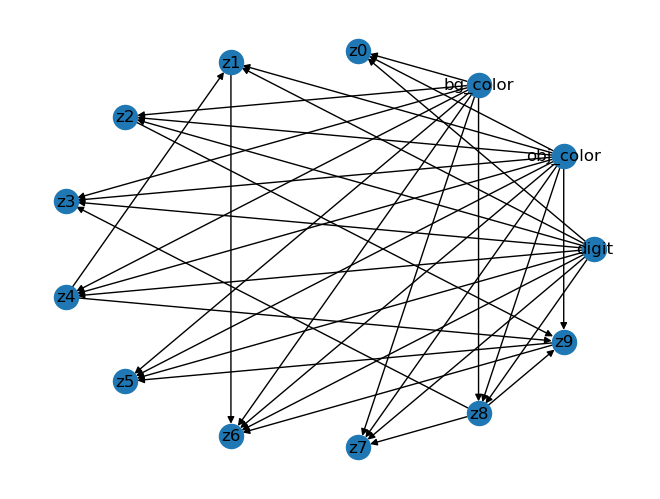

In [169]:
Z_DIM = 10
labeldict = {i: l for i, l in enumerate(['digit', 'obj_color', 'bg_color']+['z'+str(j) for j in range(Z_DIM)])}
vardist = adjacency_dist()
graph = nx.from_numpy_array(vardist.mode.cpu().numpy(), create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

In [173]:
vardist.mode.cpu().numpy()

array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]],
      dtype=float32)

In [171]:
nx.is_directed_acyclic_graph(graph)

True

In [172]:
np.array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.]]).sum()

52.0